In [1]:
from tf_helper import add_support, do_resize, resize, fft2d, fftshift

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
from fourier import lowpass_g, gf

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

Lambda = tfkl.Lambda

N = 56
padx = pady = N // 2

input_shape = (N, N, 1)#datasets_info.features['image'].shape
encoded_size = 16
base_depth = 32

# probe definition
filt = lowpass_g(.4, np.ones(N))
probe = gf(((np.einsum('i,j->ij', filt, filt)) > .5).astype(float), 2)
tprobe = (tf.convert_to_tensor(probe, tf.float32)[..., None])

datasets, datasets_info = tfds.load(name='mnist',
                                        with_info=True,
                                        as_supervised=False)

def do_forward(sequential = None):
        """
        zero-pad the real-space object and then fourier transform it
        """
        if sequential is None:
                sequential = tfk.Sequential([])

        padder = tfkl.ZeroPadding2D((padx // 2, padx // 2))

        sequential.add(padder)
        sequential.add(tfk.Input(shape = (N, N, 1)))

        sequential.add(Lambda(lambda inp: tprobe * inp))

        sequential.add(Lambda(lambda resized: (fft2d(
                tf.squeeze(tf.cast(resized, tf.complex64))
        ))))
        sequential.add(Lambda(lambda X: tf.math.real(tf.math.conj(X) * X) / N**2))
        sequential.add(Lambda(lambda psd:
                                                    tf.expand_dims(
                                                            tf.math.sqrt(
                        fftshift(psd, (-2, -1))), 3)))
        return sequential

def _preprocess(sample):
        image = tf.cast(tf.image.resize(sample['image'], [N, N]),
                                        tf.float32) / 255.  # Scale to unit interval.
        rmod = do_forward(do_resize(N))
        rmod.compile(loss='mse')
        orig = tf.identity(image)
        image = rmod(image)#rmod.predict(image)
        return image, image, orig

train_dataset = (datasets['train']
                 .batch(256)
                 .map(_preprocess)
                 .cache()
                 .prefetch(tf.data.AUTOTUNE)
                 .shuffle(int(10e3)))

eval_dataset = (datasets['test']
                                .batch(256)
                                .map(_preprocess)
                                .cache()
                                .prefetch(tf.data.AUTOTUNE))

prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
                                                reinterpreted_batch_ndims=1)

encoder = tfk.Sequential([
        tfkl.InputLayer(input_shape=input_shape),
        tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
        tf.keras.layers.BatchNormalization(),
        tfkl.Conv2D(base_depth, 5, strides=1,
                                padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2D(base_depth, 5, strides=2,
                                padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2D(2 * base_depth, 5, strides=1,
                                padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2D(2 * base_depth, 5, strides=2,
                                padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2D(4 * encoded_size, 7, strides=1,
                                padding='valid', activation=tf.nn.leaky_relu),
        tfkl.Flatten(),
        tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),
               activation=None),
        tfpl.MultivariateNormalTriL(
                encoded_size,
                activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
])

decoder = tfk.Sequential([
        tfkl.InputLayer(input_shape=[encoded_size]),
        tfkl.Reshape([1, 1, encoded_size]),
        tf.keras.layers.BatchNormalization(),
        tfkl.Conv2DTranspose(2 * base_depth, 7, strides=1,
                         padding='valid', activation=tf.nn.leaky_relu),
        tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2DTranspose(2 * base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2DTranspose(base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),

        tf.keras.layers.BatchNormalization(),
        tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
                                padding='same', activation=tf.nn.sigmoid),

   tfkl.Reshape((input_shape[0] // 2, input_shape[1] // 2, 1)),

])

decoder2 = tfk.Sequential([
        tfkl.InputLayer(input_shape = tf.TensorShape([None, None, None])),
        do_forward(),
        tfpl.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc = t, scale = 0.01))),
])

vae = tfk.Model(inputs=encoder.inputs,
                                outputs=decoder2(decoder(encoder.outputs[0])))

negloglik = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
                        loss=negloglik)

_ = vae.fit(train_dataset,
                        epochs=10,
                        validation_data=eval_dataset)

x_orig = next(iter(eval_dataset))[2][:10]

x = next(iter(eval_dataset))[0][:10]

xhat = vae(x)
assert isinstance(xhat, tfd.Distribution)

2023-09-04 14:18:51.056415: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-04 14:18:51.142006: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-04 14:18:51.599441: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ollie/anaconda3/envs/tf/lib/
2023-09-04 14:18:51.599484: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.


Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.


Epoch 1/10


2023-09-04 14:18:57.629489: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-09-04 14:18:58.664772: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


235/235 [==============================] - ETA: 0s - loss: 19894.8164WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


235/235 [==============================] - 17s 48ms/step - loss: 19894.8164 - val_loss: 26084.8281
Epoch 2/10
235/235 [==============================] - ETA: 0s - loss: 7776.6880WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


235/235 [==============================] - 10s 44ms/step - loss: 7776.6880 - val_loss: 9413.8867
Epoch 3/10
235/235 [==============================] - ETA: 0s - loss: 6446.1577WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


235/235 [==============================] - 10s 44ms/step - loss: 6446.1577 - val_loss: 6387.7202
Epoch 4/10
235/235 [==============================] - ETA: 0s - loss: 5964.9941WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


235/235 [==============================] - 10s 45ms/step - loss: 5964.9941 - val_loss: 5948.2251
Epoch 5/10
235/235 [==============================] - ETA: 0s - loss: 5724.8081WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


235/235 [==============================] - 10s 44ms/step - loss: 5724.8081 - val_loss: 5867.9683
Epoch 6/10
235/235 [==============================] - ETA: 0s - loss: 5557.9248WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


235/235 [==============================] - 10s 45ms/step - loss: 5557.9248 - val_loss: 5466.6782
Epoch 7/10
235/235 [==============================] - ETA: 0s - loss: 5298.3159WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


235/235 [==============================] - 10s 45ms/step - loss: 5298.3159 - val_loss: 4223.1899
Epoch 8/10
235/235 [==============================] - ETA: 0s - loss: 2527.6536WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


235/235 [==============================] - 10s 45ms/step - loss: 2527.6536 - val_loss: 2151.2874
Epoch 9/10
235/235 [==============================] - ETA: 0s - loss: 2004.9341WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


235/235 [==============================] - 10s 45ms/step - loss: 2004.9341 - val_loss: 1773.7594
Epoch 10/10
235/235 [==============================] - ETA: 0s - loss: 1757.8142WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


235/235 [==============================] - 10s 45ms/step - loss: 1757.8142 - val_loss: 1662.6771


Input diffraction:


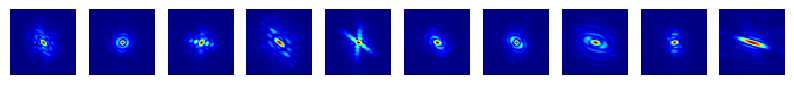

Reconstructed diffraction (modes):


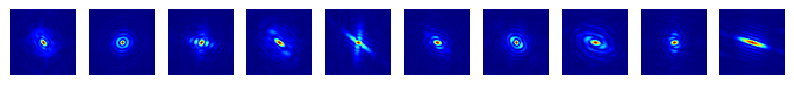

True object


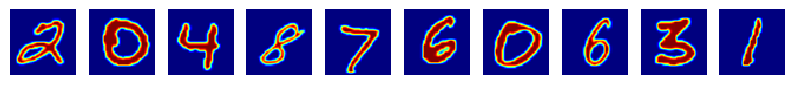

Reconstructed object (mode)


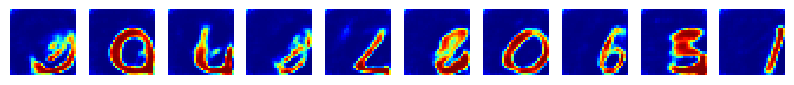

Reconstructed object variance


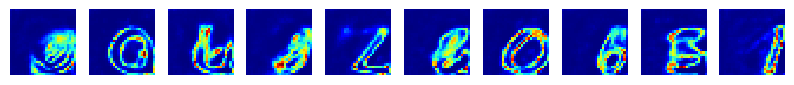

Reconstructed diffraction variance


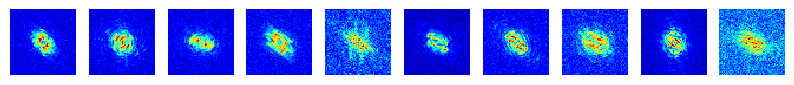

0.03345142220705829

In [13]:
def display_imgs(x, y=None, log = False, cbar = False):
    if not isinstance(x, (np.ndarray, np.generic)):
        x = np.array(x)
    n = x.shape[0]
    fig, axs = plt.subplots(1, n, figsize=(n, 2))
    if y is not None:
        fig.suptitle(np.argmax(y, axis=1))
    for i in range(n):
        if log:
                axs.flat[i].imshow(np.log(.01 + x[i].squeeze()), interpolation='none', cmap='jet')
        else:
                axs.flat[i].imshow((x[i].squeeze()), interpolation='none', cmap='jet')
        axs.flat[i].axis('off')
    if cbar:
        plt.colorbar()
    plt.show()
    plt.close()
    plt.ion()
    
import matplotlib as mpl
mpl.rcParams['figure.figsize'] =(20, 20)

print('Input diffraction:')
display_imgs(x)

print('Reconstructed diffraction (modes):')
display_imgs(xhat.mode())

print("True object")
display_imgs((x_orig))

print("Reconstructed object (mode)")
display_imgs((decoder(encoder(x).mean())))

print('Reconstructed object variance')
tmp = tf.stack([decoder(encoder(x)) for _ in range(100)])
display_imgs((np.array(tmp).std(axis = 0)))

print('Reconstructed diffraction variance')
tmp = tf.stack([vae(x).sample() for _ in range(100)])
display_imgs((np.array(tmp).std(axis = 0)))

np.percentile(np.array(tmp).std(axis = 0).ravel(), 99.9)

Example of a 'good' output. YMMV depending on random seed, hyperparams, etc.

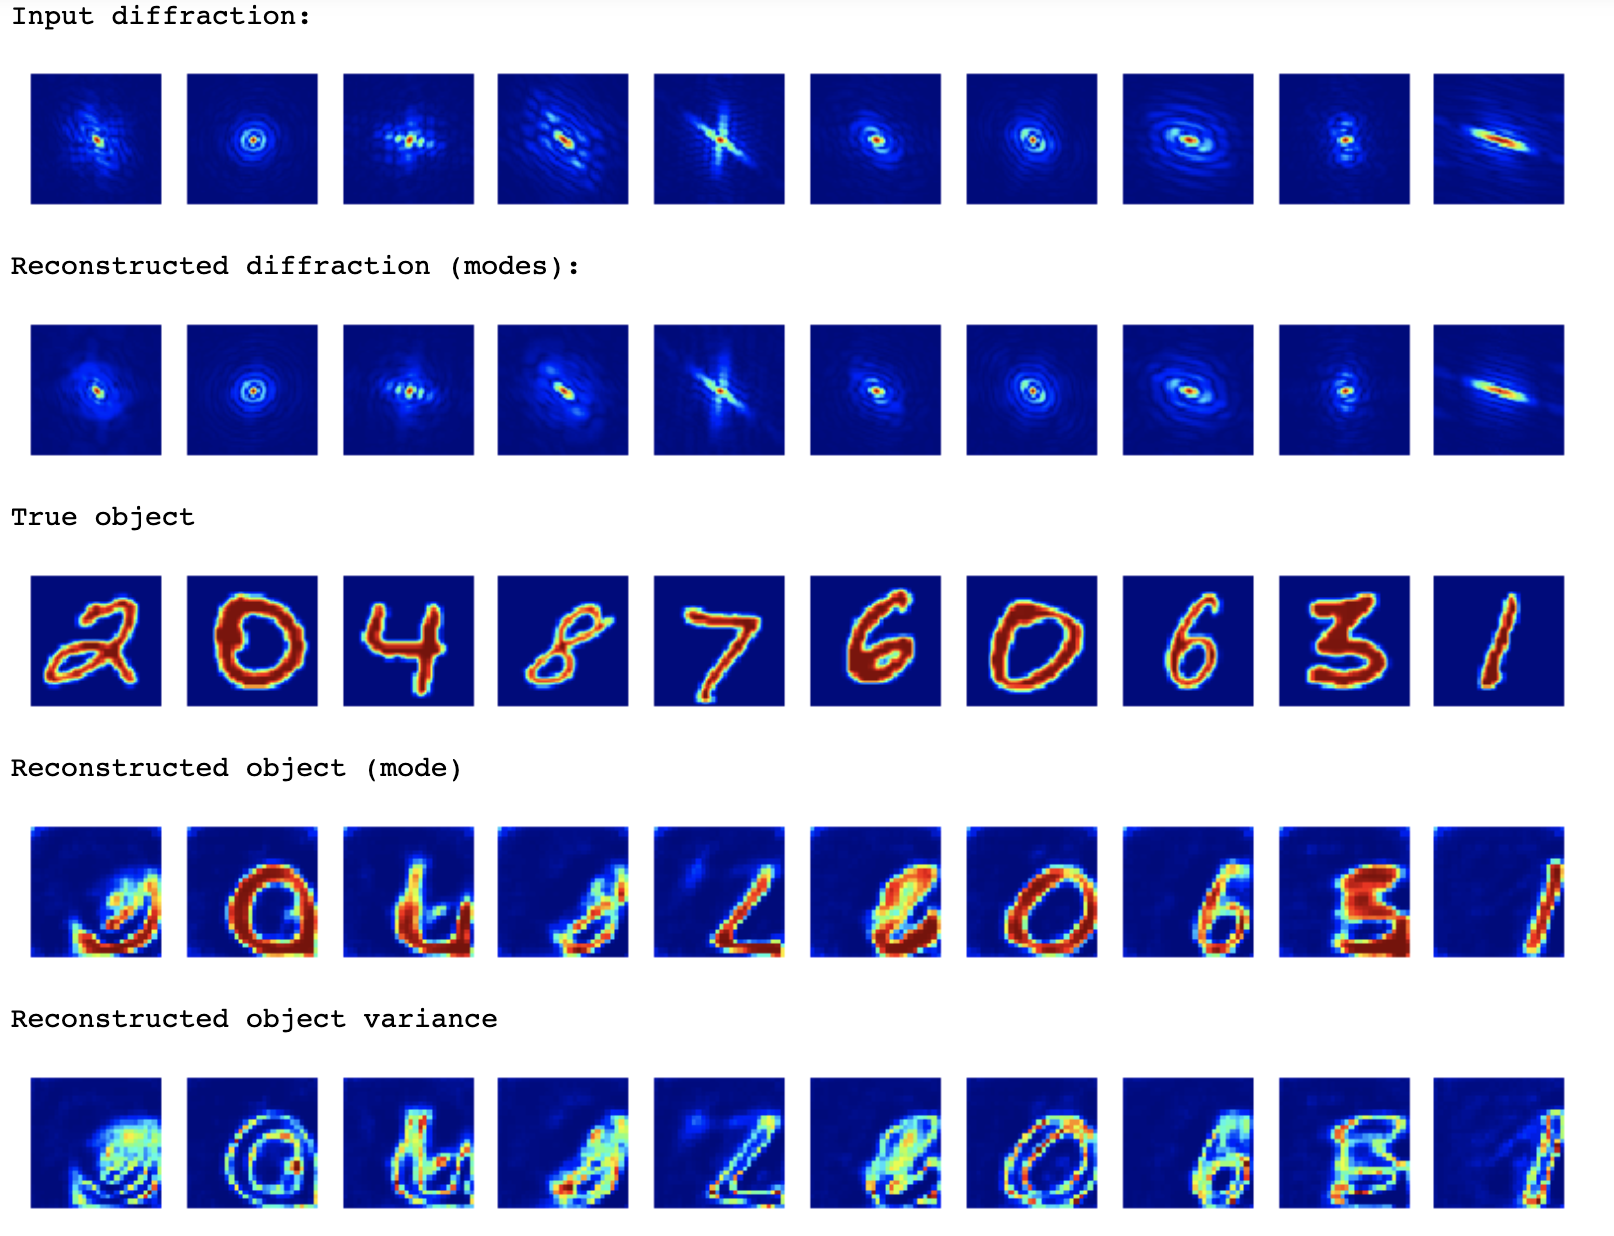